### The final classification model

With this code we are going to take the best models defined in the interpretability file and with the corresponding dataset.
The prediction outputs of these models are the input of a voting model. 
In this code we train two different voting model: 
1. The first one (Meritocratic) is based on the weight assigned to each model through an optimization
2. The second one (Democratic) is based on the number of positive predictions, of outlier, of the individual models

In [2]:
# Let's import the functions and libraries needed to run this code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tools import get_models, load_params_mix, data_preparation_prediction

from sklearn.model_selection import train_test_split

# imports library for the models
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, roc_auc_score, auc, confusion_matrix, make_scorer

In [3]:
# We load the list of models, list of datasets from the settings_models file
# In order to have the correct hyperparametrs for each model according to its dataset to create a mix model voting

file_path = "./settings_models.json"
models, datasets, votings = get_models(file_path)

inizio = {}
for dataset in datasets:
    modelli = load_params_mix(file_path, dataset)
    inizio[dataset] = modelli

print(inizio)


{'STATIONARITY': {'random_forest': {'bootstrap': 0.0, 'max_depth': 29.06528176090672, 'max_features': 12.126596503736144, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0, 'n_estimators': 549.0946720359773}, 'xgboost': {'colsample_bytree': 0.8144133043503071, 'learning_rate': 0.24247813655261816, 'max_depth': 8.782010800067567, 'n_estimators': 594.4359716551575, 'subsample': 0.8184833272531049}, 'knn': {'leaf_size': 36.72402475103034, 'n_neighbors': 1.0, 'p': 2.0}}, 'RESIDUAL': {'random_forest': {'bootstrap': 0.0, 'max_depth': 65.97743744963135, 'max_features': 11.794970311738036, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0, 'n_estimators': 454.01340508340064}, 'xgboost': {'colsample_bytree': 0.7877009561455199, 'learning_rate': 0.05396187706023991, 'max_depth': 8.611853857537138, 'n_estimators': 397.5384792090015, 'subsample': 0.9590113761376307}, 'knn': {'leaf_size': 28.936955785939546, 'n_neighbors': 1.2136759951948308, 'p': 1.2591009423510953}}, 'SPREAD': {'random_forest': {

In [4]:
# Here we are going to define how to structure the datasets for model training 
# with the corresponding division between train, validation and test set. 

# We divide the data sets into train, validation and test because to find 
# the right weights to give to the models through Bayesian optimization we use the validation set as an internal test. 
# While the test set we use it as a final evaluation

# We must do this for each dataset as the values within the datasets change but by putting 
# the same random_state we ensure that each dataset takes the same lines of each partition of the dataset
contamination = 0
dataset = {}
flag = []
flag_train = []
flag_diff_time = []

for data_name in datasets:
    support = {}
    data = pd.read_excel("./FinancialMarketData.xlsx", sheet_name=data_name)
    # Separation of feature from label
    flag_data = data['Y'].values

    if contamination == 0:
        num_ones = np.count_nonzero(flag == 1)
        contamination = num_ones  / flag_data.shape[0]

    date =  data['Data'].values
    data = data.drop(['Data', 'Y'], axis=1)
    data = pd.DataFrame(data)
    support["data"] = data

    support["X_train"], support["X_test"], support["y_train"], support["y_test"] = train_test_split(data, flag_data, test_size=0.2, stratify=flag_data, random_state=79)
    support["X_train"], support["X_val"], support["y_train"], support["y_val"] = train_test_split(support["X_train"], support["y_train"], test_size=0.5, stratify=support["y_train"], random_state=79)

    if data_name == "DIFF_TIME":
        flag_diff_time = support["y_test"]

    if len(flag) == 0 and len(flag_train) == 0:
        # here we are going to take test sets of the labels once is enough 
        # because taking the same random_state ensures the same separation 
        # of the rows and since the labels are the same for all the datasets 
        # then only once is enough
        flag = support["y_test"]
        flag_val = support["y_val"]

    dataset[data_name] = support

print(len(flag))


223


In [5]:
# Here we train the models identified as the best performers found in the interpretability file

# imports library for the models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, roc_auc_score, auc, confusion_matrix, make_scorer
from sklearn.neighbors import KNeighborsClassifier

prediction_train = {}
prediction_test = {}
prediction_val = {}

set_valutazione = []

# We load the SPREAD dataset and the best hyperparameters of the random forest
use = dataset["SPREAD"]
print("RandomForestClassifier: ", "SPREAD")
params_random_forest = inizio["SPREAD"]["random_forest"]

# Training of the model random forest on the DATA set
random_forest_model_spread = RandomForestClassifier(
        class_weight={0: (1-contamination), 1: contamination}, 
        random_state=79,
        n_estimators=int(params_random_forest["n_estimators"]),
        max_depth=int(params_random_forest["max_depth"]),
        min_samples_split=int(params_random_forest["min_samples_split"]),
        min_samples_leaf=int(params_random_forest["min_samples_leaf"]),
        max_features=int(params_random_forest["max_features"]),
        bootstrap=(True if params_random_forest["bootstrap"] else False),
    )

random_forest_model_spread.fit(use["X_train"], use["y_train"])
anomaly_predictions_random = random_forest_model_spread.predict(use["X_test"])

anomaly_scores_isolation = random_forest_model_spread.predict_proba(use["X_test"])[:, 1]
prediction_train["random_forest_model_spread"] = random_forest_model_spread.predict_proba(use["X_train"])[:, 1]
prediction_val["random_forest_model_spread"] = random_forest_model_spread.predict_proba(use["X_val"])[:, 1]
prediction_test["random_forest_model_spread"] = random_forest_model_spread.predict_proba(use["X_test"])[:, 1]

# Here we train the model random forest on the STATIONARITY set
use = dataset["STATIONARITY"]
print("RandomForestClassifier: ", "STATIONARITY")
params_random_forest = inizio["STATIONARITY"]["random_forest"]

random_forest_model_stationarity = RandomForestClassifier(
        class_weight={0: (1-contamination), 1: contamination}, 
        random_state=79,
        n_estimators=int(params_random_forest["n_estimators"]),
        max_depth=int(params_random_forest["max_depth"]),
        min_samples_split=int(params_random_forest["min_samples_split"]),
        min_samples_leaf=int(params_random_forest["min_samples_leaf"]),
        max_features=int(params_random_forest["max_features"]),
        bootstrap=(True if params_random_forest["bootstrap"] else False),
    )

random_forest_model_stationarity.fit(use["X_train"], use["y_train"])
anomaly_predictions_random = random_forest_model_stationarity.predict(use["X_test"])
prediction_train["random_forest_model_stationarity"] = random_forest_model_stationarity.predict_proba(use["X_train"])[:, 1]
prediction_val["random_forest_model_stationarity"] = random_forest_model_stationarity.predict_proba(use["X_val"])[:, 1]
prediction_test["random_forest_model_stationarity"] = random_forest_model_stationarity.predict_proba(use["X_test"])[:, 1]

# Here we train the model xgboost on the SPREAD set
use = dataset["SPREAD"]
params_xgboost = inizio["SPREAD"]["xgboost"]

print("XGBClassifier: ", "SPREAD")
xgboost_model_spread = XGBClassifier(
        n_estimators=int(params_xgboost["n_estimators"]),
        learning_rate=params_xgboost["learning_rate"],
        max_depth=int(params_xgboost["max_depth"]),
        subsample=params_xgboost["subsample"],
        colsample_bytree=params_xgboost["colsample_bytree"],
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

xgboost_model_spread.fit(use["X_train"], use["y_train"])
anomaly_predictions_xgboost = xgboost_model_spread.predict(use["X_test"])
set_valutazione.append(anomaly_predictions_xgboost)
prediction_train["xgboost_model_spread"] = xgboost_model_spread.predict_proba(use["X_train"])[:, 1]
prediction_val["xgboost_model_spread"] = xgboost_model_spread.predict_proba(use["X_val"])[:, 1]
prediction_test["xgboost_model_spread"] = xgboost_model_spread.predict_proba(use["X_test"])[:, 1]

# Here we train the model xgboost on the STATIONARITY set
use = dataset["EWS"]
params_xgboost = inizio["EWS"]["xgboost"]

print("XGBClassifier: ", "EWS")
xgboost_model_ews = XGBClassifier(
        n_estimators=int(params_xgboost["n_estimators"]),
        learning_rate=params_xgboost["learning_rate"],
        max_depth=int(params_xgboost["max_depth"]),
        subsample=params_xgboost["subsample"],
        colsample_bytree=params_xgboost["colsample_bytree"],
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

xgboost_model_ews.fit(use["X_train"], use["y_train"])
anomaly_predictions_xgboost = xgboost_model_ews.predict(use["X_test"])
set_valutazione.append(anomaly_predictions_xgboost)
prediction_train["xgboost_model_ews"] = xgboost_model_ews.predict_proba(use["X_train"])[:, 1]
prediction_val["xgboost_model_ews"] = xgboost_model_ews.predict_proba(use["X_val"])[:, 1]
prediction_test["xgboost_model_ews"] = xgboost_model_ews.predict_proba(use["X_test"])[:, 1]

# Here we train the model knn on the EWS set
use = dataset["EWS"]
print("KNeighborsClassifier: ", "EWS")
params_knn = inizio["EWS"]["knn"]
knn_model_ews = KNeighborsClassifier(
        n_neighbors=int(params_knn["n_neighbors"]),
        leaf_size=int(params_knn["leaf_size"]),
        p=int(params_knn["p"])
    )

# Fit the model with our train set
knn_model_ews.fit(use["X_train"], use["y_train"])
anomaly_predictions_knn = knn_model_ews.predict(use["X_test"])
set_valutazione.append(anomaly_predictions_knn)
prediction_train["knn_model_ews"] = knn_model_ews.predict(use["X_train"])
prediction_val["knn_model_ews"] = knn_model_ews.predict(use["X_val"])
prediction_test["knn_model_ews"] = knn_model_ews.predict(use["X_test"])

# Here we train the model knn on the STATIONARITY set
use = dataset["STATIONARITY"]
print("KNeighborsClassifier: ", "STATIONARITY")
params_knn_stationarity = inizio["STATIONARITY"]["knn"]
knn_model_stationarity = KNeighborsClassifier(
        n_neighbors=int(params_knn["n_neighbors"]),
        leaf_size=int(params_knn["leaf_size"]),
        p=int(params_knn["p"])
    )

# Fit the model with our train set
knn_model_stationarity.fit(use["X_train"], use["y_train"])
anomaly_predictions_knn = knn_model_stationarity.predict(use["X_test"])
set_valutazione.append(anomaly_predictions_knn)
prediction_train["knn_model_stationarity"] = knn_model_stationarity.predict(use["X_train"])
prediction_val["knn_model_stationarity"] = knn_model_stationarity.predict(use["X_val"])
prediction_test["knn_model_stationarity"] = knn_model_stationarity.predict(use["X_test"])

prediction_train = pd.DataFrame(prediction_train)
prediction_val = pd.DataFrame(prediction_val)

prediction_test = pd.DataFrame(prediction_test)
prediction_test.head()

RandomForestClassifier:  SPREAD
RandomForestClassifier:  STATIONARITY
XGBClassifier:  SPREAD
XGBClassifier:  EWS
KNeighborsClassifier:  EWS
KNeighborsClassifier:  STATIONARITY


/Users/michelebersani/opt/anaconda3/lib/python3.8/site-packages/threadpoolctl.py:1195: RuntimeWarning: libc not found. The ctypes module in Python 3.8 is maybe too old for this OS.
  warnings.warn(


,random_forest_model_spread,random_forest_model_stationarity,xgboost_model_spread,xgboost_model_ews,knn_model_ews,knn_model_stationarity
0,0.000000,0.005464,0.000049,0.000081,0,0
1,0.001025,0.010929,0.000106,0.000508,0,0
2,0.059110,0.018370,0.002067,0.006218,0,0
3,0.035716,0.843352,0.001056,0.001872,0,0
4,0.001025,0.000000,0.000571,0.000345,0,0


In [6]:

from bayes_opt import BayesianOptimization

# We create this function to collect the output prediction of each model
def classifies_anomalies(type, weights):
    
    pred = []

    if type == "val":
        # We ask individual models to extrapolate the anomaly probability for that model from validation set
        pred.append(np.array(prediction_val["random_forest_model_spread"]))
        pred.append(np.array(prediction_val["random_forest_model_stationarity"]))
        pred.append(np.array(prediction_val["xgboost_model_spread"]))
        pred.append(np.array(prediction_val["xgboost_model_ews"]))
        pred.append(np.array(prediction_val["knn_model_ews"]))
        pred.append(np.array(prediction_val["knn_model_stationarity"]))
    elif type == "test":
        # We ask individual models to extrapolate the anomaly probability for that model from test set
        pred.append(np.array(prediction_test["random_forest_model_spread"]))
        pred.append(np.array(prediction_test["random_forest_model_stationarity"]))
        pred.append(np.array(prediction_test["xgboost_model_spread"]))
        pred.append(np.array(prediction_test["xgboost_model_ews"]))
        pred.append(np.array(prediction_test["knn_model_ews"]))
        pred.append(np.array(prediction_test["knn_model_stationarity"]))
        
    # Creation of the voting model
    weighted_pred = np.dot(weights, pred)

    # Threshold for the label
    a = 0.5
    final_test_preds = np.where(weighted_pred > a, 1, 0)

    return final_test_preds


# We define the function to identify the correct hyperparameters in the BayesianOptimization
def objective(random_forest_model_spread_weight, random_forest_model_stationarity_weight, xgboost_model_spread_weight, xgboost_model_ews_weight, knn_model_ews_weight, knn_model_stationarity_weight):
    weights_param = [random_forest_model_spread_weight, random_forest_model_stationarity_weight, xgboost_model_spread_weight, xgboost_model_ews_weight, knn_model_ews_weight, knn_model_stationarity_weight]
    
    normalized_weights = []

    for weight in weights_param:
        normalized_weights.append(weight / sum(weights_param))

    pred_class = classifies_anomalies("val", normalized_weights)
    score = f1_score(pred_class, flag_val)

    return score 

# Define the hyperparameter space
pbounds = {
    'random_forest_model_spread_weight': (0, 1),
    'random_forest_model_stationarity_weight': (0, 1),
    'xgboost_model_spread_weight': (0, 1),
    'xgboost_model_ews_weight': (0, 1),
    'knn_model_ews_weight': (0, 1),
    'knn_model_stationarity_weight': (0, 1)
}

params_voting = {}


optimizer_voting = BayesianOptimization(f=objective, pbounds=pbounds, random_state=42)
optimizer_voting.maximize(init_points=10, n_iter=50)

print("Migliori iperparametri:")
print(optimizer_voting.max)

params_voting = optimizer_voting.max["params"]

|   iter    |  target   | knn_mo... | knn_mo... | random... | random... | xgboos... | xgboos... |
-------------------------------------------------------------------------------------------------
| 1         | 0.7553    | 0.3745    | 0.9507    | 0.732     | 0.5987    | 0.156     | 0.156     |
| 2         | 0.7407    | 0.05808   | 0.8662    | 0.6011    | 0.7081    | 0.02058   | 0.9699    |
| 3         | 0.776     | 0.8324    | 0.2123    | 0.1818    | 0.1834    | 0.3042    | 0.5248    |
| 4         | 0.7594    | 0.4319    | 0.2912    | 0.6119    | 0.1395    | 0.2921    | 0.3664    |
| 5         | 0.7619    | 0.4561    | 0.7852    | 0.1997    | 0.5142    | 0.5924    | 0.04645   |
| 6         | 0.7459    | 0.6075    | 0.1705    | 0.06505   | 0.9489    | 0.9656    | 0.8084    |
| 7         | 0.7619    | 0.3046    | 0.09767   | 0.6842    | 0.4402    | 0.122     | 0.4952    |
| 8         | 0.7196    | 0.03439   | 0.9093    | 0.2588    | 0.6625    | 0.3117    | 0.5201    |
| 9         | 0.7594

Accuracy: 0.9013452914798207
Precision: 0.75
Recall: 0.8125
F1-score: 0.78
ROC AUC: 0.8691071428571429


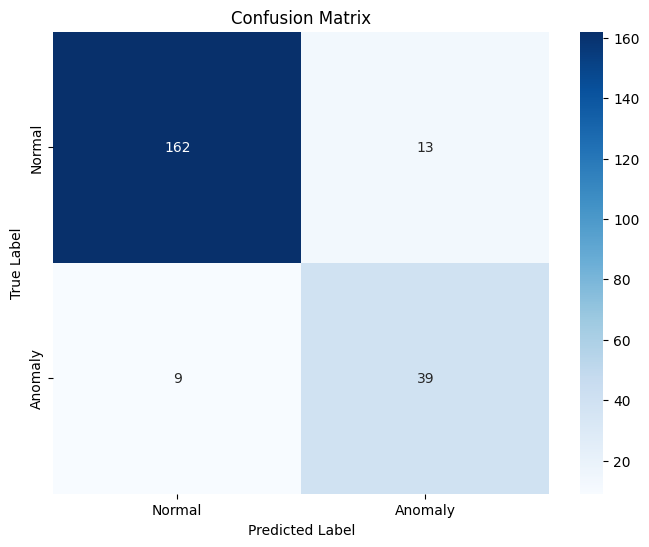

In [7]:
weights_param = [params_voting["random_forest_model_spread_weight"], params_voting["random_forest_model_stationarity_weight"], params_voting["xgboost_model_spread_weight"], params_voting["xgboost_model_ews_weight"], params_voting["knn_model_ews_weight"], params_voting["knn_model_stationarity_weight"]]
normalized_weights = []

# we do this in order to renormalize the weights so that the sum of weights is one
for weight in weights_param:
        normalized_weights.append(weight / sum(weights_param))

pred_class_test = classifies_anomalies("test", normalized_weights)

y_test = flag

conf_matrix = confusion_matrix(y_test, pred_class_test)
weights_model_score = {}

weights_model_score["accuracy"] = accuracy_score(y_test, pred_class_test)
weights_model_score["precision"] = precision_score(y_test, pred_class_test)
weights_model_score["recall"] = recall_score(y_test, pred_class_test)
weights_model_score["f1_score"] = f1_score(y_test, pred_class_test)
weights_model_score["roc_auc"] = roc_auc_score(y_test, pred_class_test)

print("Accuracy:", weights_model_score["accuracy"])
print("Precision:", weights_model_score["precision"])
print("Recall:", weights_model_score["recall"])
print("F1-score:", weights_model_score["f1_score"] )
print("ROC AUC:", weights_model_score["roc_auc"])


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Accuracy: 0.9237668161434978
Precision: 0.7924528301886793
Recall: 0.875
F1-score: 0.8316831683168316
ROC AUC: 0.9060714285714285


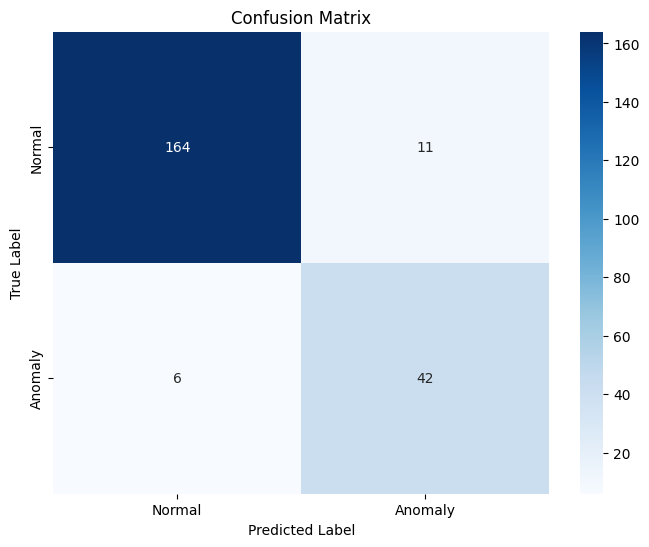

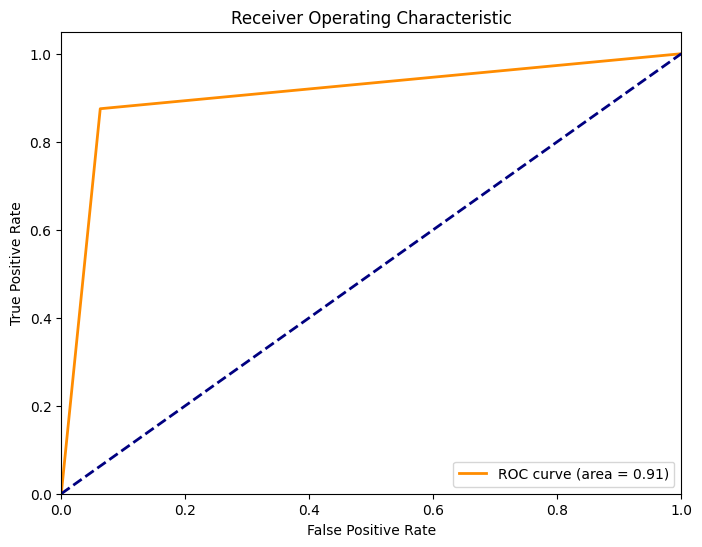

In [8]:
# Here we do the normal voting (The Second one)
test_preds = np.column_stack((prediction_test["random_forest_model_spread"], prediction_test["random_forest_model_stationarity"], prediction_test["xgboost_model_spread"], prediction_test["xgboost_model_ews"] , prediction_test["knn_model_ews"],  prediction_test["knn_model_stationarity"]))

# Apply majority voting = more than the half of the number of models
final_test_preds_ = np.where(np.sum(test_preds, axis=1) > 3, 1, 0)

y_test = flag 

# Compute confusion matrix for test predictions
conf_matrix = confusion_matrix(y_test, final_test_preds_)

vote_model_score = {}
vote_model_score["loss"] = 0
vote_model_score["accuracy_deep"] = 0

vote_model_score["accuracy"] = accuracy_score(y_test, final_test_preds_)
vote_model_score["precision"] = precision_score(y_test, final_test_preds_)
vote_model_score["recall"] = recall_score(y_test, final_test_preds_)
vote_model_score["f1_score"] = f1_score(y_test, final_test_preds_)
vote_model_score["roc_auc"] = roc_auc_score(y_test, final_test_preds_)

print("Accuracy:", vote_model_score["accuracy"])
print("Precision:", vote_model_score["precision"])
print("Recall:", vote_model_score["recall"])
print("F1-score:", vote_model_score["f1_score"])
print("ROC AUC:", vote_model_score["roc_auc"])


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, final_test_preds_)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



Below is the function that should be called if you want to classify data and it uses the final model ews_1 with the voting democratic method.

In this case the performances we see are tested on the entire dataset for a demonstration of use

In [9]:
# This function represents the function that is called when we want to classify 
# a set of data using the previously driven voting model
def classifies_anomalies_voting(data):
    # preparation of SPREAD and STATIONARY data
    preprocessing_data = data_preparation_prediction("./settings_models.json", data, ["SPREAD", "STATIONARITY"])
    dataset_spread = preprocessing_data["SPREAD"]
    dataset_stationarity = preprocessing_data["STATIONARITY"]
    dataset_ews = data
    
    pred = []

    # We ask individual models to extrapolate the anomaly probability for that model
    pred.append(np.array(random_forest_model_spread.predict(dataset_spread)))
    pred.append(np.array(random_forest_model_stationarity.predict(dataset_stationarity)))
    pred.append(np.array(xgboost_model_spread.predict(dataset_spread)))
    pred.append(np.array(xgboost_model_ews.predict(dataset_ews)))
    pred.append(np.array(knn_model_ews.predict(dataset_ews)))
    pred.append(np.array(knn_model_stationarity.predict(dataset_stationarity)))

    test_preds = np.column_stack(pred)

    # Apply majority voting
    final_test_preds = np.where(np.sum(test_preds, axis=1) > 3, 1, 0)

    return final_test_preds


    

In [10]:
file_path = './FinancialMarketData.xlsx'
data = pd.read_excel(file_path, sheet_name='EWS')
flag_try_model = data['Y'].values
date =  data['Data'].values
data = data.drop(['Data', 'Y'], axis=1)
data_try_model = pd.DataFrame(data)
data_try_model.head()

# We ask to classify the data with the voting model
prediction = classifies_anomalies_voting(data_try_model)
print(prediction)

[0 0 0 ... 0 0 0]


Accuracy: 0.9378937893789379
Precision: 0.875
Recall: 0.8270042194092827
F1-score: 0.8503253796095445
ROC AUC: 0.8974838030684859


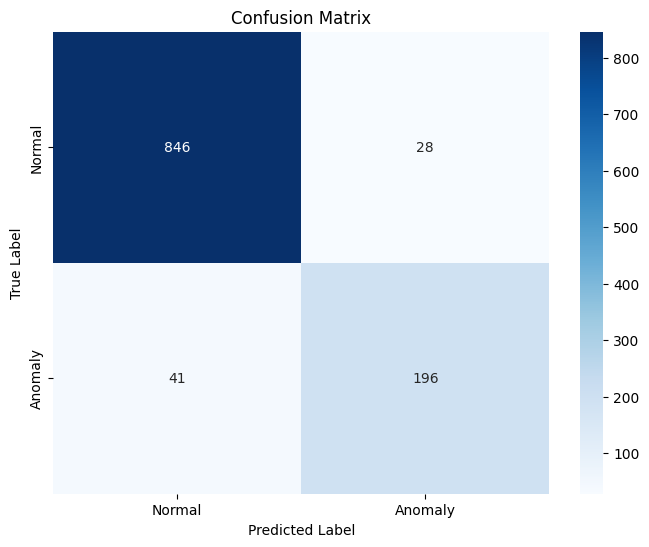

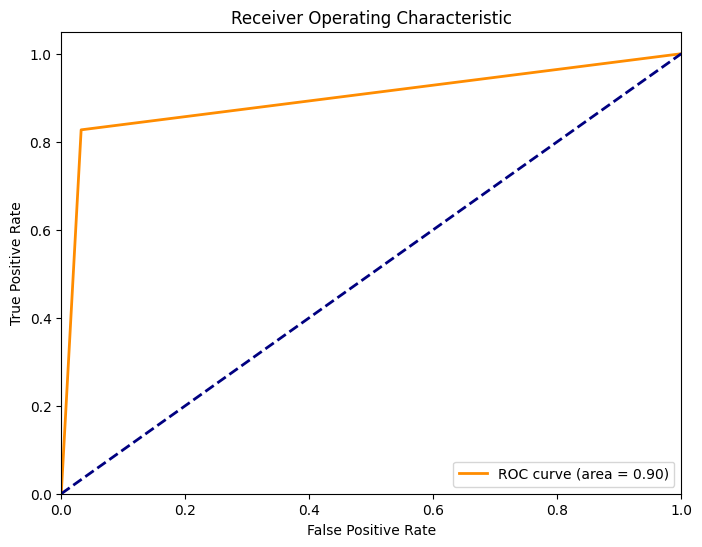

In [11]:
conf_matrix = confusion_matrix(flag_try_model, prediction)
weights_model_score = {}

weights_model_score["accuracy"] = accuracy_score(flag_try_model, prediction)
weights_model_score["precision"] = precision_score(flag_try_model, prediction)
weights_model_score["recall"] = recall_score(flag_try_model, prediction)
weights_model_score["f1_score"] = f1_score(flag_try_model, prediction)
weights_model_score["roc_auc"] = roc_auc_score(flag_try_model, prediction)

print("Accuracy:", weights_model_score["accuracy"])
print("Precision:", weights_model_score["precision"])
print("Recall:", weights_model_score["recall"])
print("F1-score:", weights_model_score["f1_score"] )
print("ROC AUC:", weights_model_score["roc_auc"])


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(flag_try_model, prediction)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()